In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import StandardScaler as SS
from sklearn.model_selection import train_test_split as tts

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.datasets import make_moons, make_blobs as mb, load_breast_cancer as lbc, load_iris as li

In [2]:
def do_Kfold(model,X,y,k,scaler = None, random_state = 146):
    from sklearn.model_selection import KFold
    
    kf = KFold(n_splits=k, random_state = random_state, shuffle=True)

    train_scores = []
    test_scores = []

    for idxTrain, idxTest in kf.split(X):
        Xtrain = X[idxTrain, :]
        Xtest = X[idxTest, :]
        ytrain = y[idxTrain]
        ytest = y[idxTest]
        if scaler != None:
            Xtrain = scaler.fit_transform(Xtrain)
            Xtest = scaler.transform(Xtest)

        model.fit(Xtrain,ytrain)

        train_scores.append(model.score(Xtrain,ytrain))
        test_scores.append(model.score(Xtest,ytest))
        
    return train_scores, test_scores

In [3]:
def compare_classes(actual, predicted, names=None):
    '''Function returns a confusion matrix, and overall accuracy given:
            Input:  actual - a list of actual classifications
                    predicted - a list of predicted classifications
                    names (optional) - a list of class names
    '''
    accuracy = sum(actual==predicted)/actual.shape[0]
    
    classes = pd.DataFrame(columns = ['Actual', 'Predicted'])
    classes['Actual'] = actual
    classes['Predicted'] = predicted

    conf_mat = pd.crosstab(classes['Actual'], classes['Predicted'])
    
    if type(names) != type(None):
        conf_mat.index = names
        conf_mat.index.name = 'Actual'
        conf_mat.columns = names
        conf_mat.columns.name = 'Predicted'
    
    print('Accuracy = ' + format(accuracy, '.2f'))
    return conf_mat, accuracy

In [4]:
def plot_groups(points, groups, colors, 
               ec='black', ax='None',s=30, alpha=0.5,
               figsize=(6,6)):
    '''Creates a scatter plot, given:
            Input:  points (array)
                    groups (an integer label for each point)
                    colors (one rgb tuple for each group)
                    ec (edgecolor for markers, default is black)
                    ax (optional handle to an existing axes object to add the new plot on top of)
            Output: handles to the figure (fig) and axes (ax) objects
    '''
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Create a new plot, unless something was passed for 'ax'
    if ax == 'None':
        fig,ax = plt.subplots(figsize=figsize)
    else:
        fig = plt.gcf()
    
    for i,lbl in enumerate(np.unique(groups)):
        idx = (groups==lbl)
        ax.scatter(points[idx,0], points[idx,1],color=colors[i],
                    ec=ec,alpha=alpha,label = lbl,s=s)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    return fig, ax

In [5]:
def get_colors(N, map_name='rainbow'):
    '''Returns a list of N colors from a matplotlib colormap
            Input: N = number of colors, and map_name = name of a matplotlib colormap
    
            For a list of available colormaps: 
                https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
    '''
    import matplotlib
    cmap = matplotlib.cm.get_cmap(name=map_name)
    n = np.linspace(0,1,N)
    colors = cmap(n)
    return colors

## DATA 201 - $k$-nearest neighbors (k-NN)

Our topic this week is on **classification** techniques.  Classification, like all of the methods we've seen so far, refers to types of **supervised learning**. 

The first technique we'll discuss is called $k$-nearest neighbors, which simply classifies points according to the classifications of their nearest neighbors ($k$ is a hyperparameter)

/tmp/ipykernel_99/2362476425.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap(name=map_name)


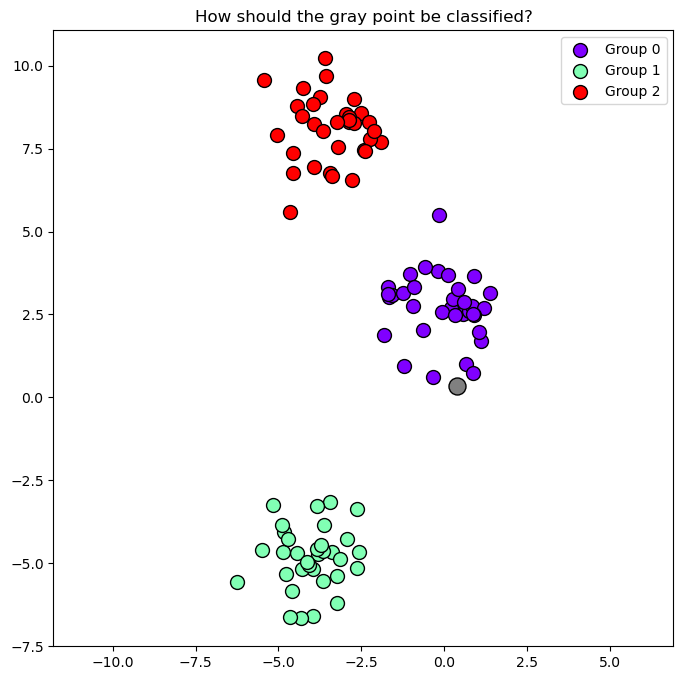

In [6]:
# Specify how many blobs
n_groups = 3
# Specify how many total points
n_points = 100
# Specify how many dimensions (how many features)
n_feats = 2

np.random.seed(146)
data = mb(n_samples = n_points, n_features=n_feats, centers = n_groups)
X = data[0]
y = data[1]

colors = get_colors(n_groups)

# Make a plot of this data, color each group separately
plt.figure(figsize = [8,8])
for yi in np.unique(y):
    # Plot the rows of data with the current value of yi
    idx = (y==yi)
    plt.scatter(X[idx,0], X[idx,1],color=colors[yi], ec='k',s=100, label = 'Group ' + str(yi))

# Create a new data point
random_point = np.random.random(size=n_feats)
# Add this point to the plot
plt.scatter(random_point[0], random_point[1], color='grey', s=150, ec='k')

plt.legend()
plt.title('How should the gray point be classified?')
plt.axis('equal')
plt.show()

In [7]:
knn = KNN(n_neighbors = 5)
knn.fit(X,y)

KNeighborsClassifier()

In [10]:
knn.predict(random_point.reshape(1,-1))

array([0])

In [13]:
knn.predict_proba(random_point.reshape(1,-1))

array([[1., 0., 0.]])

In [14]:
#Get the neighbors
neighbors = knn.kneighbors([random_point], return_distance = False)[0]
neighbors

array([91, 80, 51, 28, 96])

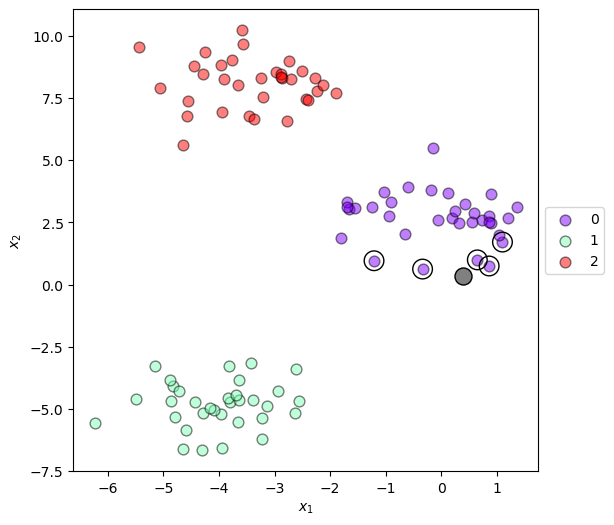

In [15]:
#plot neighbors
fig, ax = plot_groups(X,y,colors,s = 60, ec = 'k')
ax.scatter(X[neighbors,0],X[neighbors,1], color = 'none', s = 200, ec = 'k')
ax.scatter(random_point[0], random_point[1], color='grey', s=150, ec='k')

### Part 2) Finding an optimal value for the number of neighbors (the K in KNN)

### Example using the breast cancer data

In [16]:
data = lbc()
X = data.data
X_names = data.feature_names
y = data.target
y_names = data.target_names

In [18]:
print(y_names)

['malignant' 'benign']


In [19]:
X.shape

(569, 30)

/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


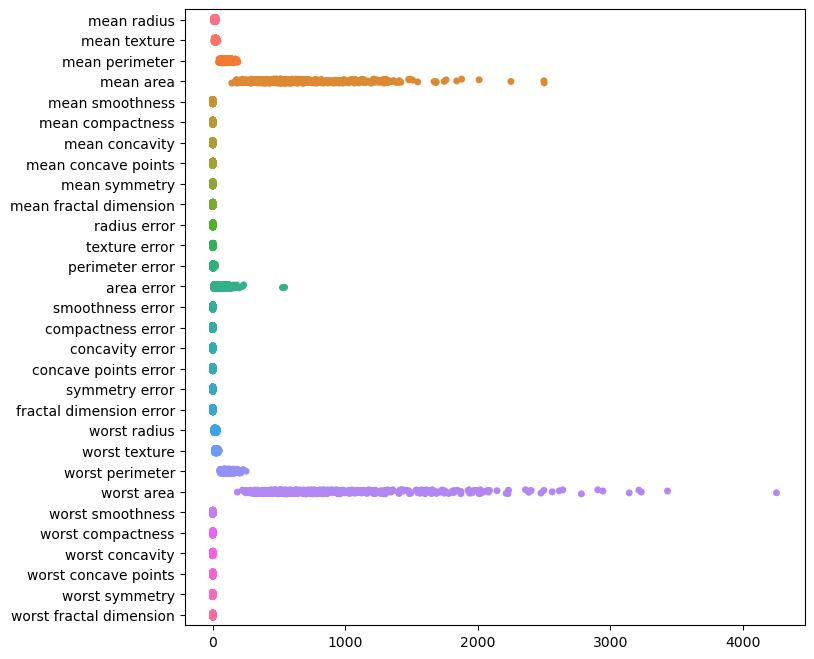

In [20]:
import seaborn as sns
plt.figure(figsize = [8,8])
sns.stripplot(data = pd.DataFrame(X,columns = X_names), orient = 'h')
plt.show()

In [21]:
neighbor_range = np.array(range(2,20))

train=[]
test=[]

k = 40 #larger value of k, why not leave one out?

for n_neighbors in neighbor_range:
    knn = KNN(n_neighbors = n_neighbors)
    tr,te = do_Kfold(knn, X, y, k, SS())
    train.append(np.mean(tr))
    test.append(np.mean(te))

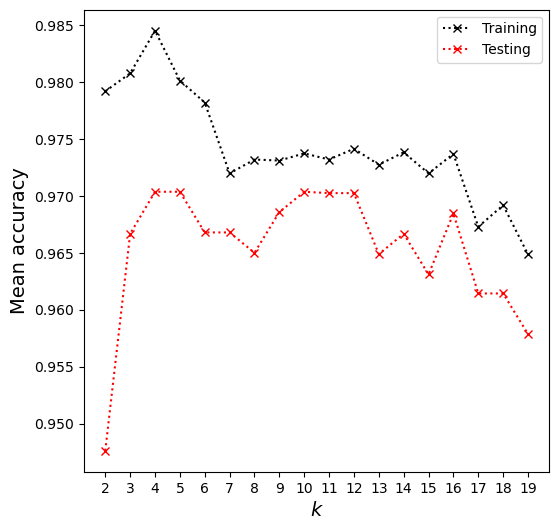

In [22]:
plt.figure(figsize=(6,6))
plt.plot(neighbor_range, train, ':xk', label='Training')
plt.plot(neighbor_range, test, ':xr', label='Testing')
plt.ylabel('Mean accuracy', fontsize=14)
plt.xlabel('$k$',fontsize=14)
plt.xticks(neighbor_range)
plt.legend()
plt.show()

In [23]:
idx = test == np.max(test)
neighbor_range[idx]

array([ 4,  5, 10])

In [24]:
neighbors = 5 #which value should we use?
knn = KNN(n_neighbors=neighbors)

In [25]:
k = 40
tr,te = do_Kfold(knn,X,y,k, SS())

/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


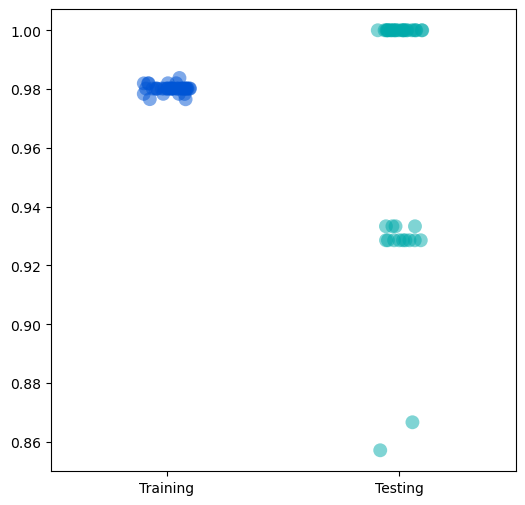

In [26]:
plt.figure(figsize = (6,6))
sns.stripplot(data = pd.DataFrame(zip(tr,te), columns = ['Training', 'Testing']), size=10, palette = 'winter',
             alpha = 0.5, jitter = True)
plt.show()

Can we visualize which points are being misclassified?

- Look at a single instance of the model
- Choose a method to reduce the dimensionality of the data

In [27]:
Xtrain,Xtest,ytrain,ytest = tts(X,y,test_size=0.2,random_state=146)

In [28]:
ss = SS()
Xtrain = ss.fit_transform(Xtrain)
Xtest = ss.transform(Xtest)

In [30]:
neighbors=5
knn = KNN(n_neighbors=neighbors)
knn.fit(Xtrain,ytrain)
y_pred = knn.predict(Xtest)

In [31]:
idx_wrong = y_pred != ytest
idx_wrong

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False])

In [33]:
pca = PCA(n_components=2)

/tmp/ipykernel_99/2362476425.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap(name=map_name)


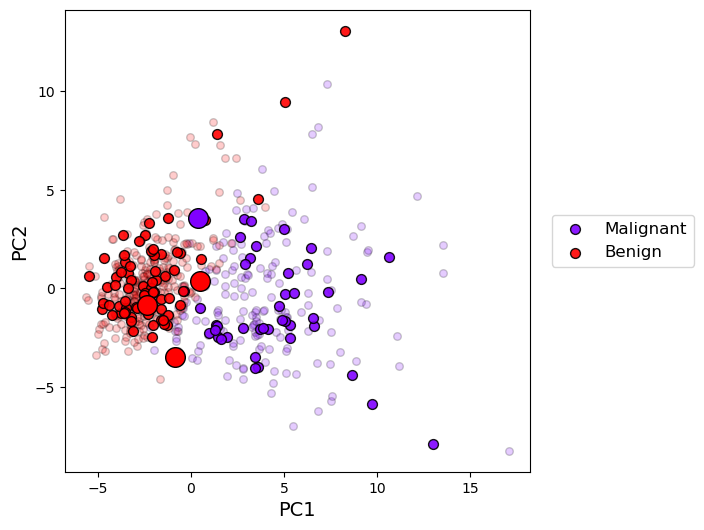

In [34]:
Xtrain_pca = pca.fit_transform(Xtrain)
Xtest_pca = pca.transform(Xtest)

# Get some colors
colors = get_colors(len(np.unique(y)))

# Show the training data
fig,ax = plot_groups(Xtrain_pca, ytrain, colors, alpha = 0.2)
# Show the testing data
plot_groups(Xtest_pca, y_pred, colors, ax=ax, alpha=0.9,s=50)
# Show which of the test points were incorrectly labeled
plot_groups(Xtest_pca[idx_wrong], y_pred[idx_wrong], colors, ax=ax, alpha=1, s=200)
ax.set_xlabel('PC1',fontsize=14)
ax.set_ylabel('PC2',fontsize=14)
h,l = ax.get_legend_handles_labels()
ax.get_legend().remove()
ax.legend(h[2:4], ['Malignant', 'Benign'], fontsize = 12, bbox_to_anchor = [1.2,0.5], loc = 'center')
plt.show()

Let's look at the **confusion matrix**.There is a built-in confusion matrix function in scikit-learn but we will use a function already written for you called compare_classes:

In [35]:
y_pred = knn.predict(Xtest)
cm,acc = compare_classes(ytest,y_pred,y_names)
print(acc)
cm

Accuracy = 0.96
0.9649122807017544


Predicted,malignant,benign
Actual,,
malignant,41,3
benign,1,69


---
### Part 3) Should all votes be counted equally?

In all of the previous examples, we consider each of a data point's $k$ nearest neighbors equally.  However, what if some of those points are farther away than others?  Should they all be considered equal when trying to classify a point?  

One way to modify this algorithm is to give each data point a weight, based on the inverse of its distance to the point we are trying to classify.  For example, if one point was 2 units away, then we would give it a weight of 1/2, and if another point was 100 units away, we would give it a much smaller weight of 1/100.


In [ ]:
# Specify how many blobs
n_groups = 3
# Specify how many total points
n_points = 100
# Specify how many dimensions (how many features)
n_feats = 2

np.random.seed(32)
data = mb(n_samples = n_points, n_features=n_feats, centers = n_groups)
X = data[0]
y = data[1]

colors = get_colors(n_groups)

# Make a plot of this data, color each group separately
fig, ax = plot_groups(X, y, colors,alpha=0.9,s=50)

# Create a new data point
random_point = [2.67,7]
# Add this point to the plot
ax.scatter(random_point[0], random_point[1], color='grey', s=150, ec='k')

plt.legend()
plt.title('How should the gray point be classified?')
plt.axis('equal')
plt.show()

In [ ]:
#Which are the nearest neighbors?
#What are their distances?
distances = np.sum((random_point - X)**2,axis=1)**0.5

In [ ]:
df = pd.DataFrame(distances)
top_5 = df.sort_values(0)[:5].index.values

In [ ]:
# Specify how many blobs
n_groups = 3
# Specify how many total points
n_points = 100
# Specify how many dimensions (how many features)
n_feats = 2

np.random.seed(32)
data = mb(n_samples = n_points, n_features=n_feats, centers = n_groups)
X = data[0]
y = data[1]

colors = ['violet','forestgreen','red']

# Make a plot of this data, color each group separately
fig, ax = plot_groups(X, y, colors,alpha=0.9,s=50)
ax.scatter(X[top_5,0], X[top_5,1], color = 'none',s = 150, ec = 'k')

# Create a new data point
random_point = [2.67,7]
# Add this point to the plot
ax.scatter(random_point[0], random_point[1], color='grey', s=150, ec='k')


h,l = ax.get_legend_handles_labels()
ax.legend(h[:3], ['Group 0', 'Group 1', 'Group 2'], fontsize = 12, bbox_to_anchor = [1.2,0.5], loc = 'center')
plt.title('How should the gray point be classified?')
plt.axis('equal')
plt.show()

In [ ]:
knn = KNN(n_neighbors=5)
knn.fit(X,y)
knn.predict(np.array(random_point).reshape(1,-1))

In [ ]:
knn.predict_proba(np.array(random_point).reshape(1,-1))